In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import statsmodels.formula.api as sf
%matplotlib inline


In [2]:
path = os.path.join("data", "caseStudyCleaned.csv")
df = pd.read_csv(path)
print(df.head())
df.shape

   ID  CustomerAgeinmonths  Churn1Yes0No  CHIScoreMonth0  CHIScore01  \
0   1                 67.0           0.0             0.0         0.0   
1   2                 67.0           0.0            62.0         4.0   
2   3                 55.0           0.0             0.0         0.0   
3   4                 63.0           0.0           231.0         1.0   
4   5                 57.0           0.0            43.0         1.0   

   SupportCasesMonth0  SupportCases01  SPMonth0  SP01  Logins01  \
0                 0.0             0.0       0.0   0.0       0.0   
1                 0.0             0.0       0.0   0.0       0.0   
2                 0.0             0.0       0.0   0.0       0.0   
3                 1.0             1.0       3.0   0.0     167.0   
4                 0.0             0.0       0.0   0.0       0.0   

   BlogArticles01  Views01  DaysSinceLastLogin01  
0             0.0      0.0                  31.0  
1             0.0     16.0                  31.0  
2          

(6347, 13)

1. Is Wall’s belief about the dependence of churn rates on customer age supported by the data? To get some intuition, try visualizing this dependence (Hint: no need to run any statistical tests).

(6024, 13)
(323, 13)


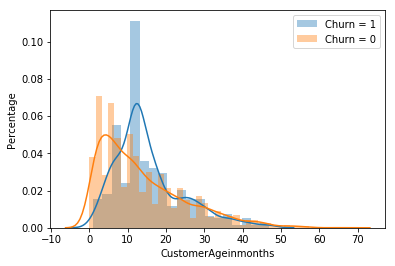

In [3]:
newDf = df.loc[df["Churn1Yes0No"] == 0]
print(newDf.shape)
newDf = df.loc[df["Churn1Yes0No"] == 1]
print(newDf.shape)
dp = sns.distplot((df.loc[df["Churn1Yes0No"] == 1])["CustomerAgeinmonths"], label="Churn = 1")
dp = sns.distplot((df.loc[df["Churn1Yes0No"] == 0])["CustomerAgeinmonths"], label="Churn = 0")
dp.set(xlabel='CustomerAgeinmonths', ylabel='Percentage')
dp.legend()

The dependence of churn rates on customer age is not supported from the plot. 
From the observation above, we can clearly see that the 2 histograms overlap a lot, especially at the right tail part.

2. To start, run a single regression model that best predicts the probability that a customer leaves.

In [45]:
yesDf = df.loc[df["Churn1Yes0No"] == 1]
noDf = df.loc[df["Churn1Yes0No"] == 0]
print(yesDf.shape)
print(noDf.shape)

yesDf1 = yesDf.sample(int(noDf.shape[0] / 2), replace = True)
noDf1 = noDf.sample(int(noDf.shape[0] / 2))
crossDf = pd.concat([yesDf1, noDf1], axis = 0)

noDf2 = noDf.sample(yesDf.shape[0])
downDf = pd.concat([yesDf, noDf2], axis = 0)

yesDf2 = yesDf.sample(noDf.shape[0], replace = True)
overDf = pd.concat([yesDf2, noDf], axis = 0)

def findBest(df):
    y = np.array([df["Churn1Yes0No"]]).T
    y = y.ravel()
    col = df.columns
    e = 0
    acc = 0
    best = ""
    bestLr = None
    bestResult = None
    for c in col:
        if c == "Churn1Yes0No" or c == "ID":
            continue
        x = np.array([df[c]]).T
        lr = LogisticRegression(solver = 'lbfgs').fit(x, y)
        result = lr.predict_proba(x)
        res = []
        for r in result:
            res.append(r[0])
        mse = mean_squared_error(y, res)
        s = lr.score(x, y)
#         print("mse " + str( mse))
        print("score " + str(s))
        if s > acc or best == "":
#             e = mse
            acc = s
            best = c
            bestLr = lr
            bestResult = res
    return best, bestLr, bestResult

originalBestC, originalBestLr, originalResult = findBest(df)
print(originalBestC + "---------- original data")

crossBestC, corssBestLr, originalResult = findBest(crossDf)
print(crossBestC + "---------- cross size data")

downBestC, downBestLr, originalResult = findBest(downDf)
print(downBestC + "---------- down size data")

overBestC, overBestLr, overBestResult = findBest(overDf)
print(overBestC + "---------- over size data")

(323, 13)
(6024, 13)
score 0.9491098156609422
score 0.9491098156609422
score 0.9491098156609422
score 0.9491098156609422
score 0.9491098156609422
score 0.9491098156609422
score 0.9491098156609422
score 0.9491098156609422
score 0.9491098156609422
score 0.9491098156609422
score 0.9483220419095636
CustomerAgeinmonths---------- original data
score 0.5131142098273572
score 0.5815073041168659
score 0.4812416998671979
score 0.5574369189907038
score 0.5561088977423638
score 0.5584329349269588
score 0.5194223107569721
score 0.549800796812749
score 0.549136786188579
score 0.5283864541832669
score 0.6321381142098274
DaysSinceLastLogin01---------- cross size data
score 0.5123839009287926
score 0.5773993808049536
score 0.5294117647058824
score 0.5294117647058824
score 0.5201238390092879
score 0.5309597523219814
score 0.5
score 0.544891640866873
score 0.5402476780185759
score 0.5170278637770898
score 0.6377708978328174
DaysSinceLastLogin01---------- down size data
score 0.5152722443559097
score 0.57

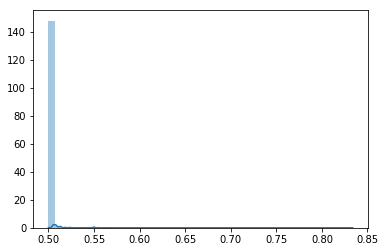

In [5]:
sns.distplot(overBestResult)

We are using the minimum MSE of the probability to decide which one is the "best prediction", because low MSE means low error of our predictions. The function findBest will find the minimum MSE variable given a data frame, and return the best column and the logistics regression model.

The original dataset is comprised of 6024 entries of **No churn** and 323 entries of **Yes churn**. Because the dataset is very unbalanced , we tried 3 different ways to balance the data.
1. Downsampled the **NO** churn set randomly from 6000 to 3000, and over sampled the **Yes** churn set to 3000 from 300. (cross data set)
2. Randomly chose about 300 to downsample the **no** churn set, match the original **yes** churn set. (down data set)
3. Over sampled the **yes** churn set to about 6000, match the original *no* churn set. (over data set)

The best variable for cross data and the down data are not consistent due to random sampling, whereas oversampled data gets the same variable despite the random oversampling. Furthermore, the MSE are similar to each other, so we have decided to use oversampled data. From the oversampled data, the best variable is "Views01".

    a. What is the predicted probability that Customer 672 will leave between December 2011 and February 2012? Is that high or low? Did that customer actually leave?

In [64]:
def testChurn(id, model):
    cus = df.iloc[id - 1][:]
    x = np.array([cus[overBestC]]).T
    x = x.reshape(-1, 1)
    print(model.predict_proba(x)[0][1])
    print(cus["Churn1Yes0No"])

testChurn(672, overBestLr)

0.4197032399093779
0.0


Probability is 0.50002. It's very close to the borderline, but prediction shows the customer should have left. However the customer didn't not actually leave.

    b. What about Customers 354 and 5,203?

In [65]:
testChurn(354, overBestLr)

0.40992383892962025
0.0


In [66]:
testChurn(5203, overBestLr)

0.44939232310844185
0.0


The probability are both similar to the first customer. They are both slightly above the threshold value and very close to the borderline. They both should have left, but neither of them actually leave.

3. How sensible is the approach with a single model? Can you suggest a better approach?

In [9]:
results = []
for i in range(df.shape[0]):
    d = df.iloc[i][:]
    x = np.array([d[overBestC]]).T
    x = x.reshape(-1, 1)
    results.append(overBestLr.predict_proba(x)[0][0])
print(np.min(results))
print(np.max(results))

0.49999999963430364
0.8338291304730353


It's not sensible. We print the minimum and the maximum of all predictions. We can tell that all the predictions are very close to 0.5, which is the threshold.
A better approach should be multiple logistic regression.

    a. Provide updated estimates of probabilities that Customers 672, 354, and 5,203 will leave.

In [58]:
import itertools
import warnings
warnings.filterwarnings("ignore")
columns = overDf.columns

x_columns = columns.drop(["ID", "Churn1Yes0No"])
allSubset = []
for i in range(len(x_columns)):
    s = set(itertools.combinations(x_columns, i + 1))
    for subS in s:
        allSubset.append(subS)
    
def stepBackward(df, allSets):
    y = df["Churn1Yes0No"]
    mses = []
    scores = []
    subSets = []
    for s in allSets:
        x = df[list(s)]
        lr = LogisticRegression(solver = 'lbfgs').fit(x, y)
#         result = lr.predict_proba(x)
#         mses.append(mean_squared_error(y, result[:, 0]))
        scores.append(lr.score(x, y))
        subSets.append(s)
    maxS = max(scores)
    index = scores.index(maxS)
    print(maxS)
    print(subSets[index])

# stepBackward(overDf, allSubset)

0.6679116865869854
('CHIScoreMonth0', 'SupportCases01', 'SPMonth0', 'SP01', 'Logins01', 'Views01', 'DaysSinceLastLogin01')


In [59]:
columns = ['CHIScoreMonth0', 'SupportCases01', 'SPMonth0', 'SP01', 'Logins01', 'Views01', 'DaysSinceLastLogin01']
x = df[columns]
y = df["Churn1Yes0No"]
improvedLr = LogisticRegression(solver = 'lbfgs').fit(x, y)

In [67]:
probs = improvedLr.predict_proba(x)
print(probs[671][1])
print(probs[353][1])
print(probs[5202][1])

0.046263151390229795
0.04818726274411093
0.08340176943410722


    b. What factors contribute the most to the predicted probabilities that these customers will leave?

4. Answer Wall’s “ultimate question”: provide the list of 100 customers with highest churn
probabilities and the top three drivers of churn for each customer.